In [1]:
from typing import Tuple
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from scipy import signal
from scipy.stats import skew, kurtosis
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.feature_selection import SelectKBest, f_classif

from ppg_data import load_ppg_raw_data
from ppg_features import ppg_features, get_peaks

In [2]:
train_labels, train_data = load_ppg_raw_data("data/train8_reformat.xlsx")
test_labels, test_data = load_ppg_raw_data("data/test8_reformat.xlsx")

fs = 50 # Sampling frequency
train_features = [ppg_features(data, fs=fs) for data in train_data]
test_features = [ppg_features(data, fs=fs) for data in test_data]

In [9]:
feature_names = list(train_features[0].keys())
X_train = np.array([[f[n] for n in feature_names] for f in train_features])
X_test = np.array([[f[n] for n in feature_names] for f in test_features])

y_train = np.array(train_labels)
y_test = np.array(test_labels)

In [5]:
# scaler = StandardScaler()
# X_train = scaler.fit_transform(X_train)
# X_test = scaler.transform(X_test)

In [ ]:
# Plot all features relationship with each other
# NB: Generate a lot of plots
# feature_keys = list(train_features[0].keys())
# n_features = len(feature_keys)
# n_labels = len(set(y_train))
# colors = plt.colormaps.get_cmap("gist_ncar")(np.linspace(0, 1, n_labels))

# for i in range(n_features):
#     for j in range(i + 1, n_features):
#         plt.figure(figsize=(16, 9))
#         for label in range(n_labels):
#             plt.scatter(X_train[y_train == label, i], X_train[y_train == label, j], color=colors[label], label=label)
#         plt.xlabel(feature_keys[i])
#         plt.ylabel(feature_keys[j])
#         plt.title(f"{feature_keys[i]} vs {feature_keys[j]}")
#         plt.grid()        
#         plt.show()
        

In [4]:
1# Split PPG samples into segments based on peak detection
def segment_ppg(data, peaks):
    segments = []
    for i in range(len(peaks) - 1):
        segments.append(data[peaks[i]:peaks[i + 1]])
    return segments

train_segments = []
train_segment_labels = []
test_segments = []
test_segment_labels = []

for i in range(len(train_data)):
    peaks = get_peaks(train_data[i], fs=fs)
    segments = segment_ppg(train_data[i], peaks)
    train_segments.extend(segments)
    train_segment_labels.extend([train_labels[i]] * len(segments))

for i in range(len(test_data)):
    peaks = get_peaks(test_data[i], fs=fs)
    segments = segment_ppg(test_data[i], peaks)
    test_segments.extend(segments)
    test_segment_labels.extend([test_labels[i]] * len(segments))

# Can take a while to run
train_segment_features = [ppg_features(data, fs=fs) for data in train_segments]
test_segment_features = [ppg_features(data, fs=fs) for data in test_segments]

f:\Laval\GIF-4101_Intro_apprentissage_auto\Project\repo\projet-ml\.venv\Lib\site-packages\scipy\signal\_spectral_py.py:600: UserWarning: nperseg = 256 is greater than input length  = 33, using nperseg = 33
  freqs, _, Pxy = _spectral_helper(x, y, fs, window, nperseg, noverlap,
f:\Laval\GIF-4101_Intro_apprentissage_auto\Project\repo\projet-ml\.venv\Lib\site-packages\scipy\signal\_spectral_py.py:600: UserWarning: nperseg = 256 is greater than input length  = 32, using nperseg = 32
  freqs, _, Pxy = _spectral_helper(x, y, fs, window, nperseg, noverlap,
f:\Laval\GIF-4101_Intro_apprentissage_auto\Project\repo\projet-ml\.venv\Lib\site-packages\numpy\_core\fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
f:\Laval\GIF-4101_Intro_apprentissage_auto\Project\repo\projet-ml\.venv\Lib\site-packages\numpy\_core\_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
f:\Laval\GIF-4101_

In [5]:
# Scale the data
scaler = StandardScaler()
X_train_segment = np.array([[f[n] for n in feature_names] for f in train_segment_features])
X_test_segment = np.array([[f[n] for n in feature_names] for f in test_segment_features])

X_train_segment = scaler.fit_transform(X_train_segment)
X_test_segment = scaler.transform(X_test_segment)

y_train_segment = np.array(train_segment_labels)
y_test_segment = np.array(test_segment_labels)

# Remove NaN
X_train_segment = np.nan_to_num(X_train_segment)
X_test_segment = np.nan_to_num(X_test_segment)

In [ ]:
# feature_keys = list(train_segment_features[0].keys())
# n_features = len(feature_keys)
# n_labels = len(set(y_train_segment))
# colors = plt.colormaps.get_cmap("gist_ncar")(np.linspace(0, 1, n_labels))

# for i in range(n_features):
#     for j in range(i + 1, n_features):
#         plt.figure(figsize=(16, 9))
#         for label in range(n_labels):
#             plt.scatter(X_train_segment[y_train_segment == label, i], X_train_segment[y_train_segment == label, j], color=colors[label], label=label)
#         plt.xlabel(feature_keys[i])
#         plt.ylabel(feature_keys[j])
#         plt.title(f"{feature_keys[i]} vs {feature_keys[j]}")
#         plt.grid()
#         plt.show()

0.9158082408874801


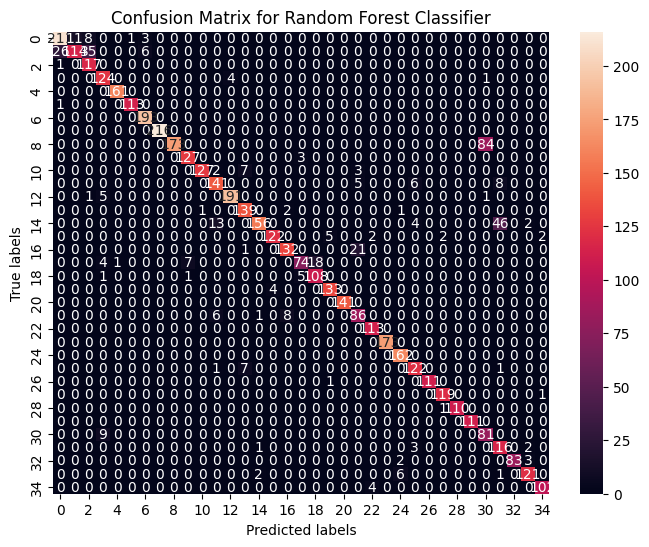

In [6]:
clf1 = RandomForestClassifier(n_estimators=100, random_state=1)
clf1.fit(X_train_segment, y_train_segment)
y_pred1 = clf1.predict(X_test_segment)
accuracy1 = accuracy_score(y_test_segment, y_pred1)
confusion_matrix1 = confusion_matrix(y_test_segment, y_pred1)

print(accuracy1)
# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix1, annot=True, fmt='d')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix for Random Forest Classifier')
plt.show()

In [ ]:
clf2 = KNeighborsClassifier(n_neighbors=5)
clf2.fit(X_train_segment, y_train_segment)
y_pred2 = clf2.predict(X_test_segment)
accuracy2 = accuracy_score(y_test_segment, y_pred2)
confusion_matrix2 = confusion_matrix(y_test_segment, y_pred2)

print(accuracy2)
# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix2, annot=True, fmt='d')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix for K-Nearest Neighbors Classifier')
plt.show()

In [14]:
clf3 = SVC(kernel='linear', C=1.5, probability=True)
clf3.fit(X_train_segment, y_train_segment)
y_pred3 = clf3.predict(X_test_segment)
accuracy3 = accuracy_score(y_test_segment, y_pred3)
confusion_matrix3 = confusion_matrix(y_test_segment, y_pred3)

print(accuracy3)
# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix3, annot=True, fmt='d')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix for Support Vector Classifier')
plt.show()


In [12]:
clf4 = MLPClassifier(hidden_layer_sizes=(100, 50), max_iter=1000)
clf4.fit(X_train_segment, y_train_segment)
y_pred4 = clf4.predict(X_test_segment)
accuracy4 = accuracy_score(y_test_segment, y_pred4)
confusion_matrix4 = confusion_matrix(y_test_segment, y_pred4)

print(accuracy4)
# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix4, annot=True, fmt='d')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix for Multi-Layer Perceptron Classifier')
plt.show()

In [73]:
clf1 = RandomForestClassifier(n_estimators=100, random_state=1)
clf2 = KNeighborsClassifier(n_neighbors=5)
clf3 = SVC(kernel='linear', C=1.5, probability=True)
clf4 = MLPClassifier(hidden_layer_sizes=(100, 50), max_iter=1000)

eclf = VotingClassifier(estimators=[
    ("rf", clf1), 
    ("knn", clf2), 
    ("svc", clf3), 
    ("mlp", clf4)
], voting="soft")

eclf.fit(X_train_segment, y_train_segment)

VotingClassifier(estimators=[('rf', RandomForestClassifier(random_state=1)),
                             ('knn', KNeighborsClassifier()),
                             ('svc',
                              SVC(C=1.5, kernel='linear', probability=True)),
                             ('mlp',
                              MLPClassifier(hidden_layer_sizes=(100, 50),
                                            max_iter=1000))],
                 voting='soft')

In [15]:
y_pred_segment = eclf.predict(X_test_segment)

accuracy_segment = accuracy_score(y_test_segment, y_pred_segment)
print("Accuracy segment:", accuracy_segment)

In [17]:
# Plot the confusion matrix
cm_segment = confusion_matrix(y_test_segment, y_pred_segment)
plt.figure(figsize=(16, 9))
sns.heatmap(cm_segment, annot=True, fmt="d")
plt.xlabel("Predicted")
plt.ylabel("Label")
plt.title("Confusion Matrix for Ensemble Classifier")
plt.show()

In [7]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import SelectKBest, chi2, RFE
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

def prepare_data(X_train, X_test):
    """Scale features to [0,1] range for chi-squared"""
    scaler = MinMaxScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    return X_train_scaled, X_test_scaled



In [10]:
X_train_scaled_segments, X_test_scaled_segments = prepare_data(X_train_segment, X_test_segment)

k = 10
# 1. Chi-squared
selector_chi2 = SelectKBest(score_func=chi2, k=k)
X_train_chi2 = selector_chi2.fit_transform(X_train_scaled_segments, y_train_segment)
X_test_chi2 = selector_chi2.transform(X_test_scaled_segments)
selected_chi2 = selector_chi2.get_support(indices=True)

# 2. RFE
rfe = RFE(LogisticRegression(max_iter=1000), n_features_to_select=k)
X_train_rfe = rfe.fit_transform(X_train_scaled_segments, y_train_segment)
X_test_rfe = rfe.transform(X_test_scaled_segments)
selected_rfe = rfe.get_support(indices=True)

# 3. Random Forest Importance
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train_scaled_segments, y_train_segment)
importances = pd.Series(rf.feature_importances_, index=feature_names)
selected_rf = importances.nlargest(k).index
selected_rf_indices = [feature_names.index(f) for f in selected_rf]

[0, 1, 8, 2, 10, 12, 15, 3]

In [11]:
X_train_scaled_segments_feature_selected_chi2 = []
X_test_scaled_segments_feature_selected_chi2 = []

for x in X_train_scaled_segments:
    X_feature_selected = []
    for i in selected_chi2:
        X_feature_selected.append(x[i])
    X_train_scaled_segments_feature_selected_chi2.append(X_feature_selected)
    
for x in X_test_scaled_segments:
    X_feature_selected = []
    for i in selected_chi2:
        X_feature_selected.append(x[i])
    X_test_scaled_segments_feature_selected_chi2.append(X_feature_selected)
    
    
X_train_scaled_segments_feature_selected_rfe = []
X_test_scaled_segments_feature_selected_rfe = []

for x in X_train_scaled_segments:
    X_feature_selected = []
    for i in selected_rfe:
        X_feature_selected.append(x[i])
    X_train_scaled_segments_feature_selected_rfe.append(X_feature_selected)
    
for x in X_test_scaled_segments:
    X_feature_selected = []
    for i in selected_rfe:
        X_feature_selected.append(x[i])
    X_test_scaled_segments_feature_selected_rfe.append(X_feature_selected)
    

X_train_scaled_segments_feature_selected_rf = []
X_test_scaled_segments_feature_selected_rf = []

for x in X_train_scaled_segments:
    X_feature_selected = []
    for i in selected_rf_indices:
        X_feature_selected.append(x[i])
    X_train_scaled_segments_feature_selected_rf.append(X_feature_selected)
    
for x in X_test_scaled_segments:
    X_feature_selected = []
    for i in selected_rf_indices:
        X_feature_selected.append(x[i])
    X_test_scaled_segments_feature_selected_rf.append(X_feature_selected)
    


[[np.float64(0.1904787410459456), np.float64(0.19059081411070594), np.float64(0.1909677579967975), np.float64(0.1904777753713177), np.float64(0.11407139805591335), np.float64(0.01240835395041038), np.float64(0.01207485729290303), np.float64(0.008999502829287964)], [np.float64(0.1895073066119467), np.float64(0.189371901503667), np.float64(0.20931950008105438), np.float64(0.18950658678247512), np.float64(0.11912132407786971), np.float64(0.017791955249896928), np.float64(0.01623689063258739), np.float64(0.014243041024407294)], [np.float64(0.1885255999557255), np.float64(0.18833736223214653), np.float64(0.2324210861379566), np.float64(0.1885252146404781), np.float64(0.12413614940443027), np.float64(0.023801050076693434), np.float64(0.023071884168451032), np.float64(0.020666785857326946)], [np.float64(0.18801623692692518), np.float64(0.18773302741016923), np.float64(0.26304727007354123), np.float64(0.18801633231307213), np.float64(0.12939188844180352), np.float64(0.03246737816079031), np.fl

In [98]:

clf1 = RandomForestClassifier(n_estimators=100, random_state=1)
clf2 = KNeighborsClassifier(n_neighbors=5)
clf3 = SVC(kernel='linear', C=1.5, probability=True)
clf4 = MLPClassifier(hidden_layer_sizes=(100, 50), max_iter=1000)

eclf = VotingClassifier(estimators=[
    ("rf", clf1), 
    ("knn", clf2), 
    ("svc", clf3), 
    ("mlp", clf4)
], voting="soft")

eclf.fit(X_train_scaled_segments_feature_selected_chi2, y_train_segment)
y_pred_segment = eclf.predict(X_test_scaled_segments_feature_selected_chi2)
accuracy_segment = accuracy_score(y_test_segment, y_pred_segment)
print("Accuracy segment:", accuracy_segment)


Accuracy segment: 0.9314580031695721


In [99]:
clf1 = RandomForestClassifier(n_estimators=100, random_state=1)
clf2 = KNeighborsClassifier(n_neighbors=5)
clf3 = SVC(kernel='linear', C=1.5, probability=True)
clf4 = MLPClassifier(hidden_layer_sizes=(100, 50), max_iter=1000)

eclf = VotingClassifier(estimators=[
    ("rf", clf1), 
    ("knn", clf2), 
    ("svc", clf3), 
    ("mlp", clf4)
], voting="soft")

eclf.fit(X_train_scaled_segments_feature_selected_rfe, y_train_segment)
y_pred_segment = eclf.predict(X_test_scaled_segments_feature_selected_rfe)
accuracy_segment = accuracy_score(y_test_segment, y_pred_segment)
print("Accuracy segment:", accuracy_segment)

Accuracy segment: 0.9374009508716323


In [100]:
clf1 = RandomForestClassifier(n_estimators=100, random_state=1)
clf2 = KNeighborsClassifier(n_neighbors=5)
clf3 = SVC(kernel='linear', C=1.5, probability=True)
clf4 = MLPClassifier(hidden_layer_sizes=(100, 50), max_iter=1000)

eclf = VotingClassifier(estimators=[
    ("rf", clf1), 
    ("knn", clf2), 
    ("svc", clf3), 
    ("mlp", clf4)
], voting="soft")

eclf.fit(X_train_scaled_segments_feature_selected_rf, y_train_segment)
y_pred_segment = eclf.predict(X_test_scaled_segments_feature_selected_rf)
accuracy_segment = accuracy_score(y_test_segment, y_pred_segment)
print("Accuracy segment:", accuracy_segment)

Accuracy segment: 0.9294770206022187


In [12]:
from sklearn.model_selection import GridSearchCV, KFold

# hyperparameters for RandomForest

param_grid_RF = {
    'n_estimators': [50, 100, 200],
    'max_depth': [5, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

rf = RandomForestClassifier(
    random_state=42
)

grid_search_RF = GridSearchCV(
    estimator=rf,
    param_grid=param_grid_RF,
    cv=KFold(n_splits=5),
    n_jobs=-1,
    verbose=2
)

grid_search_RF.fit(X_train_scaled_segments_feature_selected_rf, y_train_segment)

print(grid_search_RF.best_params_)
print(grid_search_RF.best_score_)
print(grid_search_RF.best_estimator_)
y_pred_segment = grid_search_RF.predict(X_test_scaled_segments_feature_selected_rf)
accuracy_segment = accuracy_score(y_test_segment, y_pred_segment)
print("Accuracy segment:", accuracy_segment)

Fitting 5 folds for each of 108 candidates, totalling 540 fits
{'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 200}
0.06511045451456675
RandomForestClassifier(max_depth=20, min_samples_split=5, n_estimators=200,
                       random_state=42)
Accuracy segment: 0.8975832012678289


In [13]:
# hyperparameters for KNN

param_grid_KNN = {
    'n_neighbors': [3, 5, 7, 9, 11],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}

knn = KNeighborsClassifier()

grid_search_KNN = GridSearchCV(
    estimator=knn,
    param_grid=param_grid_KNN,
    cv=KFold(n_splits=5),
    n_jobs=-1,
    verbose=2
)

grid_search_KNN.fit(X_train_scaled_segments_feature_selected_rf, y_train_segment)

print(grid_search_KNN.best_params_)
print(grid_search_KNN.best_score_)
print(grid_search_KNN.best_estimator_)
y_pred_segment = grid_search_KNN.predict(X_test_scaled_segments_feature_selected_rf)
accuracy_segment = accuracy_score(y_test_segment, y_pred_segment)
print("Accuracy segment:", accuracy_segment)


Fitting 5 folds for each of 20 candidates, totalling 100 fits
{'metric': 'manhattan', 'n_neighbors': 3, 'weights': 'distance'}
0.07087175708947999
KNeighborsClassifier(metric='manhattan', n_neighbors=3, weights='distance')
Accuracy segment: 0.9128367670364501


In [14]:
# hyperparameters for SVC

param_grid_SVC = {
    'C': [0.1, 1, 10, 100],
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid']
}

svc = SVC()

grid_search_SVC = GridSearchCV(
    estimator=svc,
    param_grid=param_grid_SVC,
    cv=KFold(n_splits=5),
    n_jobs=-1,
    verbose=2
)

grid_search_SVC.fit(X_train_scaled_segments_feature_selected_rf, y_train_segment)

print(grid_search_SVC.best_params_)
print(grid_search_SVC.best_score_)
print(grid_search_SVC.best_estimator_)
y_pred_segment = grid_search_SVC.predict(X_test_scaled_segments_feature_selected_rf)
accuracy_segment = accuracy_score(y_test_segment, y_pred_segment)
print("Accuracy segment:", accuracy_segment)

Fitting 5 folds for each of 16 candidates, totalling 80 fits
{'C': 100, 'kernel': 'poly'}
0.07471233594808177
SVC(C=100, kernel='poly')
Accuracy segment: 0.937797147385103


In [15]:
# hyperparameters for MLP

param_grid_MLP = {
    'hidden_layer_sizes': [(100,), (100, 50), (100, 50, 25)],
    'activation': [ 'logistic', 'relu'],
    'solver': ['adam', 'sgd'],
    'max_iter': [1000, 2000]
}

mlp = MLPClassifier()

grid_search_MLP = GridSearchCV(
    estimator=mlp,
    param_grid=param_grid_MLP,
    cv=KFold(n_splits=3),
    n_jobs=-1,
    verbose=2
)

grid_search_MLP.fit(X_train_scaled_segments_feature_selected_rf, y_train_segment)

print(grid_search_MLP.best_params_)
print(grid_search_MLP.best_score_)
print(grid_search_MLP.best_estimator_)
y_pred_segment = grid_search_MLP.predict(X_test_scaled_segments_feature_selected_rf)
accuracy_segment = accuracy_score(y_test_segment, y_pred_segment)
print("Accuracy segment:", accuracy_segment)

Fitting 3 folds for each of 24 candidates, totalling 72 fits
{'activation': 'logistic', 'hidden_layer_sizes': (100, 50), 'max_iter': 2000, 'solver': 'adam'}
0.03983109648963882
MLPClassifier(activation='logistic', hidden_layer_sizes=(100, 50),
              max_iter=2000)
Accuracy segment: 0.9257131537242472


In [16]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_curve, auc, precision_recall_curve
from sklearn.preprocessing import label_binarize
from itertools import cycle
import numpy as np

def plot_confusion_matrix(y_true, y_pred, classifier_name):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(16, 9))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Oranges')
    plt.title(f'Confusion Matrix for {classifier_name}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

def plot_roc_curve(y_true, y_proba, classifier_name, n_classes):
    y_true_bin = label_binarize(y_true, classes=[i for i in range(n_classes)])
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_proba[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    plt.figure(figsize=(10, 7))
    colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=2,
                 label=f'ROC curve of class {i} (area = {roc_auc[i]:0.2f})')
    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'Receiver Operating Characteristic for {classifier_name}')
    plt.legend(loc="lower right")
    plt.show()

def plot_precision_recall_curve(y_true, y_proba, classifier_name, n_classes):
    y_true_bin = label_binarize(y_true, classes=[i for i in range(n_classes)])
    precision = dict()
    recall = dict()
    for i in range(n_classes):
        precision[i], recall[i], _ = precision_recall_curve(y_true_bin[:, i], y_proba[:, i])

    plt.figure(figsize=(10, 7))
    colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
    for i, color in zip(range(n_classes), colors):
        plt.plot(recall[i], precision[i], color=color, lw=2,
                 label=f'Precision-Recall curve of class {i}')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f'Precision-Recall Curve for {classifier_name}')
    plt.legend(loc="lower left")
    plt.show()

def compare_classifiers(classifiers, X_test, y_test, n_classes):
    plt.figure(figsize=(15, 10))
    
    for clf_name, clf in classifiers.items():
        y_proba = clf.predict_proba(X_test)
        y_true_bin = label_binarize(y_test, classes=[i for i in range(n_classes)])
        
        # Plot ROC curve
        fpr = dict()
        tpr = dict()
        roc_auc = dict()
        for i in range(n_classes):
            fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_proba[:, i])
            roc_auc[i] = auc(fpr[i], tpr[i])
        
        for i, color in zip(range(n_classes), cycle(['aqua', 'darkorange', 'cornflowerblue'])):
            plt.plot(fpr[i], tpr[i], lw=2, label=f'{clf_name} class {i} (AUC = {roc_auc[i]:0.2f})')
    
    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve Comparison')
    plt.legend(loc="lower right")
    plt.show()

In [18]:
#classifiers with best hyperparameters
# RandomForest
n_estimators = grid_search_RF.best_params_['n_estimators']
max_depth = grid_search_RF.best_params_['max_depth']
min_samples_split = grid_search_RF.best_params_['min_samples_split']
min_samples_leaf = grid_search_RF.best_params_['min_samples_leaf']
clf_RF = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth, min_samples_split=min_samples_split, min_samples_leaf=min_samples_leaf, random_state=42)
# KNN
n_neighbors = grid_search_KNN.best_params_['n_neighbors']
weights = grid_search_KNN.best_params_['weights']
metric = grid_search_KNN.best_params_['metric']
clf_KNN = KNeighborsClassifier(n_neighbors=n_neighbors, weights=weights, metric=metric)
# SVC
C = grid_search_SVC.best_params_['C']
kernel = grid_search_SVC.best_params_['kernel']
clf_SVC = SVC(C=C, kernel=kernel, probability=True)
# MLP
hidden_layer_sizes = grid_search_MLP.best_params_['hidden_layer_sizes']
activation = grid_search_MLP.best_params_['activation']
solver = grid_search_MLP.best_params_['solver']
max_iter = grid_search_MLP.best_params_['max_iter']
clf_MLP = MLPClassifier(hidden_layer_sizes=hidden_layer_sizes, activation=activation, solver=solver, max_iter=max_iter)

classifiers = {
    'Random Forest': clf_RF,
    'K-Nearest Neighbors': clf_KNN,
    'Support Vector Classifier': clf_SVC,
    'Multi-Layer Perceptron': clf_MLP
}

# Ensemble Classifier
eclf = VotingClassifier(estimators=[
    ("rf", clf_RF), 
    ("knn", clf_KNN), 
    ("svc", clf_SVC), 
    ("mlp", clf_MLP)
], voting="soft")

eclf.fit(X_train_scaled_segments_feature_selected_rf, y_train_segment)
y_pred_segment = eclf.predict(X_test_scaled_segments_feature_selected_rf)
accuracy_segment = accuracy_score(y_test_segment, y_pred_segment)
print("Accuracy segment:", accuracy_segment)

Accuracy segment: 0.9330427892234548


In [20]:
from sklearn.ensemble import StackingClassifier, GradientBoostingClassifier, AdaBoostClassifier, ExtraTreesClassifier, BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

#classifiers with best hyperparameters
# RandomForest
n_estimators = grid_search_RF.best_params_['n_estimators']
max_depth = grid_search_RF.best_params_['max_depth']
min_samples_split = grid_search_RF.best_params_['min_samples_split']
min_samples_leaf = grid_search_RF.best_params_['min_samples_leaf']
clf_RF = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth, min_samples_split=min_samples_split, min_samples_leaf=min_samples_leaf, random_state=42)
# KNN
n_neighbors = grid_search_KNN.best_params_['n_neighbors']
weights = grid_search_KNN.best_params_['weights']
metric = grid_search_KNN.best_params_['metric']
clf_KNN = KNeighborsClassifier(n_neighbors=n_neighbors, weights=weights, metric=metric)
# SVC
C = grid_search_SVC.best_params_['C']
kernel = grid_search_SVC.best_params_['kernel']
clf_SVC = SVC(C=C, kernel=kernel, probability=True)
# MLP
hidden_layer_sizes = (100, 100) # grid_search_MLP.best_params_['hidden_layer_sizes']
activation = "relu" # grid_search_MLP.best_params_['activation']
solver = "adam" #grid_search_MLP.best_params_['solver']
max_iter = 1000 #grid_search_MLP.best_params_['max_iter']
clf_MLP = MLPClassifier(hidden_layer_sizes=hidden_layer_sizes, activation=activation, solver=solver, max_iter=max_iter)

classifiers = {
    'Random Forest': clf_RF,
    'K-Nearest Neighbors': clf_KNN,
    'Support Vector Classifier': clf_SVC,
    'Multi-Layer Perceptron': clf_MLP
}

# Ensemble Classifier
eclf_voting = VotingClassifier(estimators=[
    ("rf", clf_RF), 
    ("knn", clf_KNN), 
    ("svc", clf_SVC), 
    ("mlp", clf_MLP)
], voting="soft")

eclf_voting.fit(X_train_scaled_segments_feature_selected_rf, y_train_segment)
y_pred_segment = eclf_voting.predict(X_test_scaled_segments_feature_selected_rf)
accuracy_segment = accuracy_score(y_test_segment, y_pred_segment)
print("Accuracy segment:", accuracy_segment)

eclf_voting2 = VotingClassifier(estimators=[
    ("rf", clf_RF), 
    ("knn", clf_KNN), 
    ("svc", clf_SVC), 
    ("mlp", clf_MLP)
], voting="soft")

eclf_voting2.fit(X_train_scaled_segments_feature_selected_rfe, y_train_segment)
y_pred_segment = eclf_voting2.predict(X_test_scaled_segments_feature_selected_rfe)
accuracy_segment_voting = accuracy_score(y_test_segment, y_pred_segment)
print("Accuracy segment:", accuracy_segment_voting)

eclf_voting3 = VotingClassifier(estimators=[   
    ("rf", clf_RF), 
    ("knn", clf_KNN), 
    ("svc", clf_SVC), 
    ("mlp", clf_MLP)
], voting="soft")

eclf_voting3.fit(X_train_scaled_segments_feature_selected_chi2, y_train_segment)
y_pred_segment = eclf_voting3.predict(X_test_scaled_segments_feature_selected_chi2)
accuracy_segment = accuracy_score(y_test_segment, y_pred_segment)
print("Accuracy segment:", accuracy_segment)




Accuracy segment: 0.9393819334389857
Accuracy segment: 0.9498811410459588
Accuracy segment: 0.9467115689381933


In [ ]:
eclf_stacking = StackingClassifier(estimators=[
    ("rf", clf_RF), 
    ("knn", clf_KNN), 
    ("svc", clf_SVC), 
    ("mlp", clf_MLP)
], final_estimator=clf_RF)

eclf_stacking.fit(X_train_scaled_segments_feature_selected_rf, y_train_segment)
y_pred_segment1 = eclf_stacking.predict(X_test_scaled_segments_feature_selected_rf)
accuracy_segment = accuracy_score(y_test_segment, y_pred_segment1)
print("Accuracy segment:", accuracy_segment)

eclf_stacking2 = StackingClassifier(estimators=[
    ("rf", clf_RF), 
    ("knn", clf_KNN), 
    ("svc", clf_SVC), 
    ("mlp", clf_MLP)
], final_estimator=clf_RF)

eclf_stacking2.fit(X_train_scaled_segments_feature_selected_rfe, y_train_segment)
y_pred_segment2 = eclf_stacking2.predict(X_test_scaled_segments_feature_selected_rfe)
accuracy_segment_stacking = accuracy_score(y_test_segment, y_pred_segment2)
print("Accuracy segment:", accuracy_segment_stacking)

eclf_stacking3 = StackingClassifier(estimators=[
    ("rf", clf_RF), 
    ("knn", clf_KNN), 
    ("svc", clf_SVC), 
    ("mlp", clf_MLP)
], final_estimator=clf_RF)

eclf_stacking3.fit(X_train_scaled_segments_feature_selected_chi2, y_train_segment)
y_pred_segment3 = eclf_stacking3.predict(X_test_scaled_segments_feature_selected_chi2)
accuracy_segment = accuracy_score(y_test_segment, y_pred_segment3)
print("Accuracy segment:", accuracy_segment)



In [149]:
clf_AB = AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=10), n_estimators=100, random_state=42)
clf_AB.fit(X_train_scaled_segments_feature_selected_rf, y_train_segment)
y_pred_segment = clf_AB.predict(X_test_scaled_segments_feature_selected_rf)
accuracy_segment = accuracy_score(y_test_segment, y_pred_segment)
print("Accuracy segment:", accuracy_segment)


clf_Ab2 = AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=10),n_estimators=100, random_state=42)
clf_Ab2.fit(X_train_scaled_segments_feature_selected_rfe, y_train_segment)
y_pred_segment = clf_Ab2.predict(X_test_scaled_segments_feature_selected_rfe)
accuracy_segment_AB = accuracy_score(y_test_segment, y_pred_segment)
print("Accuracy segment:", accuracy_segment)


clf_AB3 = AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=10), n_estimators=100, random_state=42)
clf_AB3.fit(X_train_scaled_segments_feature_selected_chi2, y_train_segment)
y_pred_segment = clf_AB3.predict(X_test_scaled_segments_feature_selected_chi2)
accuracy_segment = accuracy_score(y_test_segment, y_pred_segment)
print("Accuracy segment:", accuracy_segment)


Accuracy segment: 0.9160063391442155
Accuracy segment: 0.9160063391442155
Accuracy segment: 0.9156101426307448


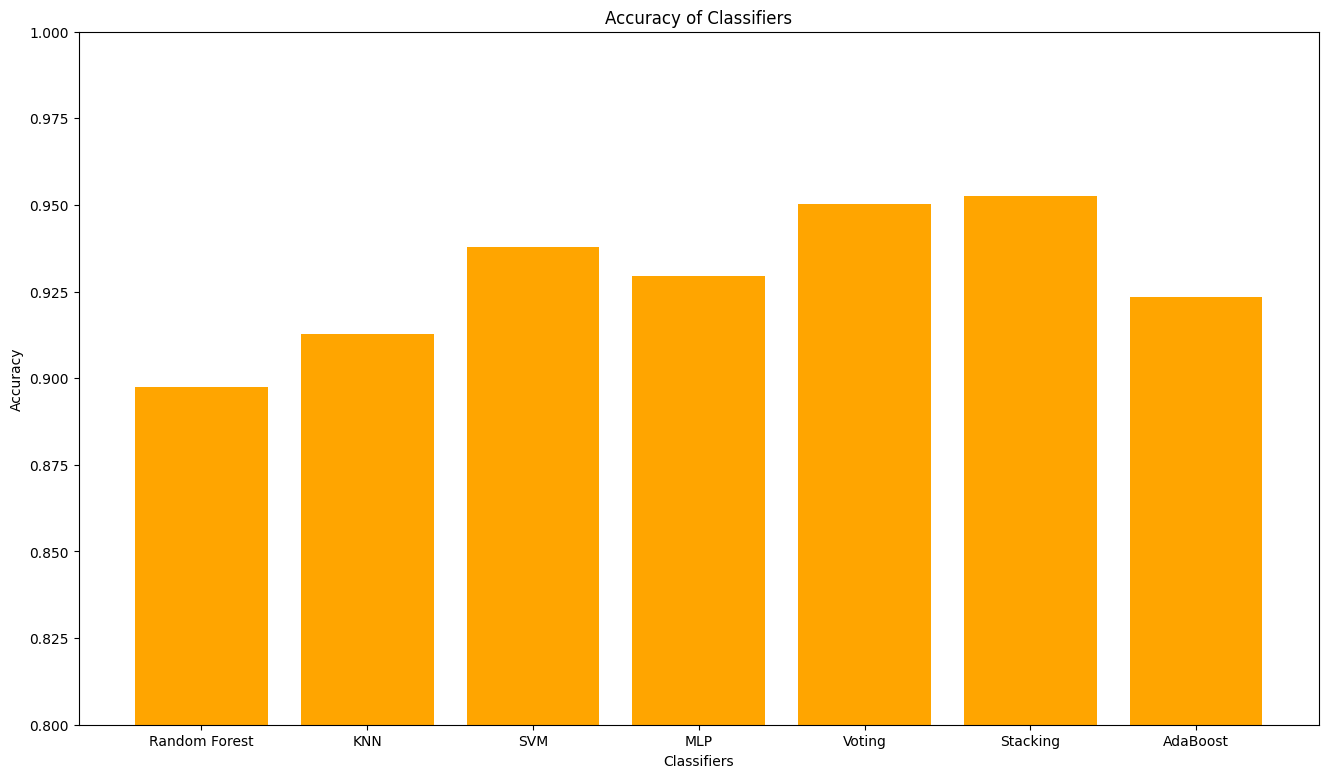

In [ ]:
# histogram of all accuracy_segments
import matplotlib.pyplot as plt
import numpy as np

# random forest
n_estimators = grid_search_RF.best_params_['n_estimators']
max_depth = grid_search_RF.best_params_['max_depth']
min_samples_split = grid_search_RF.best_params_['min_samples_split']
min_samples_leaf = grid_search_RF.best_params_['min_samples_leaf']
clf_RF = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth, min_samples_split=min_samples_split, min_samples_leaf=min_samples_leaf, random_state=42)
# KNN
n_neighbors = grid_search_KNN.best_params_['n_neighbors']
weights = grid_search_KNN.best_params_['weights']
metric = grid_search_KNN.best_params_['metric']
clf_KNN = KNeighborsClassifier(n_neighbors=n_neighbors, weights=weights, metric=metric)
# SVC
C = grid_search_SVC.best_params_['C']
kernel = grid_search_SVC.best_params_['kernel']
clf_SVC = SVC(C=C, kernel=kernel, probability=True)
# MLP
hidden_layer_sizes = (100, 100) # grid_search_MLP.best_params_['hidden_layer_sizes']
activation = "relu" # grid_search_MLP.best_params_['activation']
solver = "adam" #grid_search_MLP.best_params_['solver']
max_iter = 1000 #grid_search_MLP.best_params_['max_iter']
clf_MLP = MLPClassifier(hidden_layer_sizes=hidden_layer_sizes, activation=activation, solver=solver, max_iter=max_iter)

clf_RF.fit(X_train_scaled_segments_feature_selected_rf, y_train_segment)
y_pred_segment_RF = clf_RF.predict(X_test_scaled_segments_feature_selected_rf)
accuracy_segment_RF = accuracy_score(y_test_segment, y_pred_segment_RF)

clf_KNN.fit(X_train_scaled_segments_feature_selected_rf, y_train_segment)
y_pred_segment_KNN = clf_KNN.predict(X_test_scaled_segments_feature_selected_rf)
accuracy_segment_KNN = accuracy_score(y_test_segment, y_pred_segment_KNN)

clf_SVC.fit(X_train_scaled_segments_feature_selected_rf, y_train_segment)
y_pred_segment_SVC = clf_SVC.predict(X_test_scaled_segments_feature_selected_rf)
accuracy_segment_SVC = accuracy_score(y_test_segment, y_pred_segment_SVC)

clf_MLP.fit(X_train_scaled_segments_feature_selected_rf, y_train_segment)
y_pred_segment_MLP = clf_MLP.predict(X_test_scaled_segments_feature_selected_rf)
accuracy_segment_MLP = accuracy_score(y_test_segment, y_pred_segment_MLP)


accuracy_segments = [accuracy_segment_RF, accuracy_segment_KNN, accuracy_segment_AB, accuracy_segment_MLP, accuracy_segment_SVC, accuracy_segment_voting, accuracy_segment_stacking]
classifiers = ['Random Forest', 'KNN', 'AdaBoost', 'MLP', 'SVM', 'Voting', 'Stacking', ]



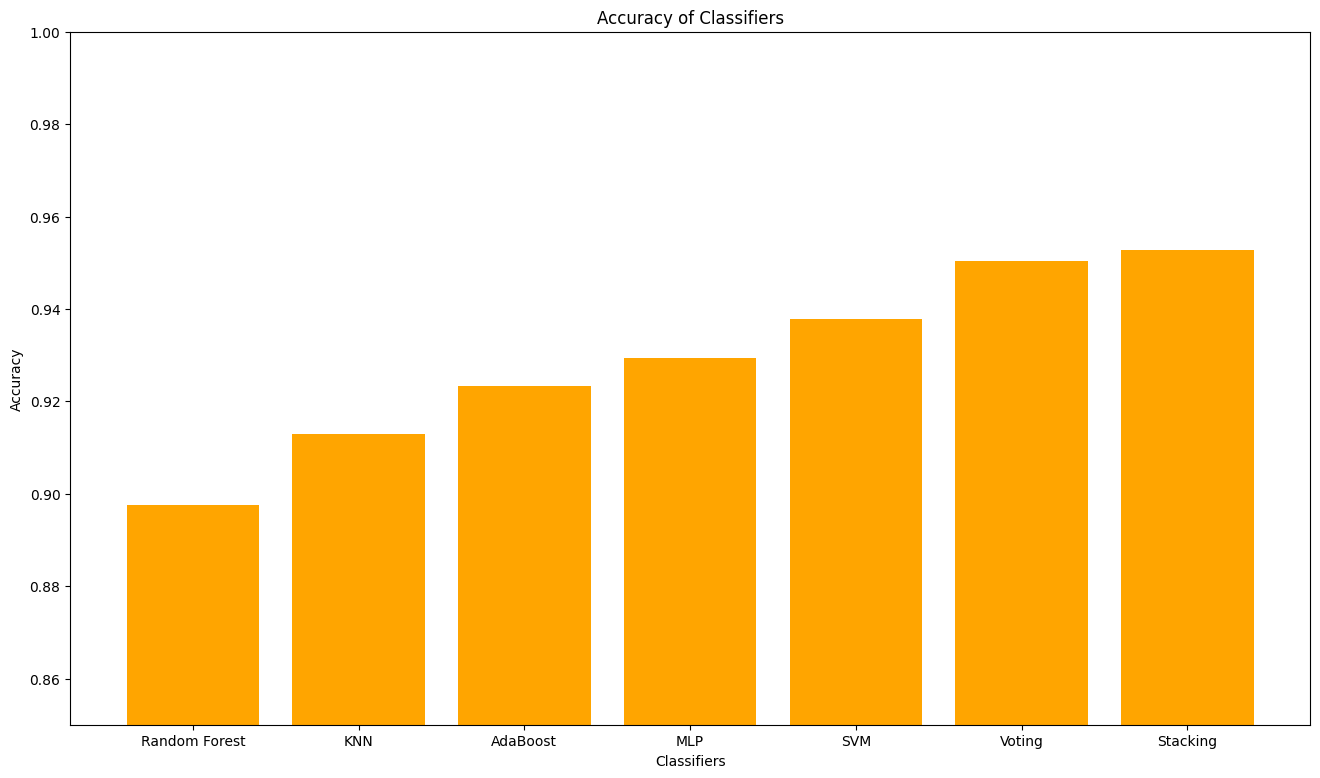

In [154]:
accuracy_segments = [accuracy_segment_RF, accuracy_segment_KNN, accuracy_segment_AB, accuracy_segment_MLP, accuracy_segment_SVC, accuracy_segment_voting, accuracy_segment_stacking]
classifiers = ['Random Forest', 'KNN', 'AdaBoost', 'MLP', 'SVM', 'Voting', 'Stacking', ]

plt.figure(figsize=(16, 9))
plt.bar(classifiers, accuracy_segments, color='Orange')
plt.xlabel('Classifiers')
plt.ylabel('Accuracy')
plt.title('Accuracy of Classifiers')
# limit y axis to 0.8 to 1
plt.ylim(0.85, 1)



plt.show()

In [ ]:
# confusion matrix of stacking classifier
plot_confusion_matrix(y_test_segment, y_pred_segment, 'Stacking Classifier')

